<a id='top'></a><a name='top'></a>
# Chapter 4: Preparing Textual Data for Statistics and Machine Learning

**Blueprints for Text Analysis Using Python**

* [Introduction](#introduction)
* [4.0 Imports and Setup](#4.0)
* [4.1 A Data Preprocessing Pipeline](#4.1)
* [4.2 Introducing the Dataset: Reddit Self-Posts](#4.2)
    - [4.2.1 Loading Data into Pandas](#4.2.1)
    - [4.2.2 Blueprint: Standardizing Attribute Names](#4.2.2)
    - [4.2.3 Saving and Loading a DataFrame](#4.2.3)
* [4.3 Cleaning Text Data](#4.3)
    - [4.3.1 Blueprint: Identify Noise with Regular Expressions](#4.3.1)
    - [4.3.2 Blueprint: Removing Noise with Regular Expressions](#4.3.2)
    - [4.3.3 Blueprint: Character Normalization with textacy](#4.3.3)
    - [4.3.4 Blueprint: Pattern-Based Data Masking with textacy](#4.3.4)
* [4.4 Tokenization](#4.4)
    - [4.4.1 Blueprint: Tokenization with Regular Expressions](#4.4.1)
    - [4.4.2 Tokenization with NLTK](#4.4.2)
    - [4.4.3 Recommendations for Tokenization](#4.4.3)
* [4.5 Linguistics Processing with spaCy](#4.5)
    - [4.5.1 Instantiating a Pipeline](#4.5.1)
    - [4.5.2 Processing Text](#4.5.2)
    - [4.5.3 Blueprint: Customizing Tokenization](#4.5.3)
    - [4.5.4 Blueprint: Working with Stop Words](#4.5.4)
    - [4.5.5 Blueprint: Extracting Lemmas Based on Part of Speech](#4.5.5)
    - [4.5.6 Blueprint: Extracting Noun Phrases](#4.5.6)
    - [4.5.7 Blueprint: Extracting Named Entities](#4.5.7)
* [4.6 Feature Extraction on a Large Dataset](#4.6)
    - [4.6.1 Blueprint: Creating One Function to Get It All](#4.6.1)
    - [4.6.2 Blueprint: Using spaCy on a Large Dataset](#4.6.2)
    - [4.6.3 Persisting the Result](#4.6.3)
    - [4.6.4 A Note on Execution Time](#4.6.4)
* [4.7 There is More](#4.7)
    - [4.7.1 Language Detection](#4.7.1)
    - [4.7.2 Spell-Checking](#4.7.2)
    - [4.7.3 Token Normalization](#4.7.3)

---
<a name='introduction'></a><a id='introduction'></a>
# Introduction
<a href="#top">[back to top]</a>

This chapter is mainly about data cleaning and tokenization.

Data cleaning in general involves not only the transformation of data into a form that can serve as the basis for analysis, but also the removal of disturbing noise. What's noise and what isn't always depends on the analysis you are going to perform. 

### Dataset

* Reddit rspct_autos.tsv.gz: [script](#rspct_autos.tsv.gz), [source](https://github.com/blueprints-for-text-analytics-python/blueprints-text/raw/master/data/reddit-selfposts/rspct_autos.tsv.gz)
* Reddit subreddit_info.csv.gz: [script](#subreddit_info.csv.gz), [source](https://github.com/blueprints-for-text-analytics-python/blueprints-text/raw/master/data/reddit-selfposts/subreddit_info.csv.gz)



### Explore

* How to set up a data preprocessing pipeline.
* How to take raw input as input, clean it, transform it, and extract basic features of textual content.
* How to use the spaCy and NLTK packages for feature extraction.
* How to use regex for data cleaning.

---
<a name='4.0'></a><a id='4.0'></a>
# 4.0 Imports and Setup
<a href="#top">[back to top]</a>

In [1]:
# Start with clean project
# !rm -f *.ftz 
# !rm -f *.pkl 
# !rm -f *.db 
# !rm -f *.gz 
# !rm -f *.txt 
# !rm -f *.csv 
# !rm -f *.py

In [2]:
req_file = "requirements_04.txt"

In [3]:
%%writefile {req_file}
fasttext
isort
scikit-learn-intelex
symspellpy
textacy
tqdm
watermark

Writing requirements_04.txt


In [4]:
import sys

IS_COLAB = 'google.colab' in sys.modules
if IS_COLAB:
    print("Installing packages")
    !pip install --upgrade --quiet -r {req_file}
else:
    print("Running locally.")

Running locally.


In [5]:
%%writefile imports.py
# Place at top to patch scikit-learn algorithms
from sklearnex import patch_sklearn # isort:skip
patch_sklearn() # isort:skip

import html
import locale
import math
import pprint
import pprint as pp
import random
import re
import sqlite3
import warnings
from collections import Counter

import fasttext
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
import textacy
import textacy.preprocessing as tprep
from matplotlib import pyplot as plt
from spacy import displacy
from spacy.lang.en import English
from spacy.tokenizer import Tokenizer
from spacy.util import (compile_infix_regex, compile_prefix_regex,
                        compile_suffix_regex)
from textacy.extract.kwic import keyword_in_context
from textacy.preprocessing.resources import RE_URL
from tqdm.auto import tqdm
from watermark import watermark
from wordcloud import WordCloud

Writing imports.py


In [6]:
!isort imports.py
!cat imports.py

# Place at top to patch scikit-learn algorithms
from sklearnex import patch_sklearn # isort:skip
patch_sklearn() # isort:skip

import html
import locale
import math
import pprint
import pprint as pp
import random
import re
import sqlite3
import warnings
from collections import Counter

import fasttext
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
import textacy
import textacy.preprocessing as tprep
from matplotlib import pyplot as plt
from spacy import displacy
from spacy.lang.en import English
from spacy.tokenizer import Tokenizer
from spacy.util import (compile_infix_regex, compile_prefix_regex,
                        compile_suffix_regex)
from textacy.extract.kwic import keyword_in_context
from textacy.preprocessing.resources import RE_URL
from tqdm.auto import tqdm
from watermark import watermark
from wordcloud import WordCloud


In [7]:
# Place at top to patch scikit-learn algorithms
from sklearnex import patch_sklearn # isort:skip
patch_sklearn() # isort:skip

import html
import locale
import math
import pprint
import pprint as pp
import random
import re
import sqlite3
import warnings
from collections import Counter

import fasttext
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
import textacy
import textacy.preprocessing as tprep
from matplotlib import pyplot as plt
from spacy import displacy
from spacy.lang.en import English
from spacy.tokenizer import Tokenizer
from spacy.util import (compile_infix_regex, compile_prefix_regex,
                        compile_suffix_regex)
from textacy.extract.kwic import keyword_in_context
from textacy.preprocessing.resources import RE_URL
from tqdm.auto import tqdm
from watermark import watermark
from wordcloud import WordCloud

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [8]:
def HR():
    print("-"*40)
    
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"

locale.getpreferredencoding = getpreferredencoding
warnings.filterwarnings('ignore')
BASE_DIR = '.'
sns.set_style("darkgrid")
tqdm.pandas(desc="progress-bar")
pp = pprint.PrettyPrinter(indent=4)

print(watermark(iversions=True, globals_=globals(),python=True, machine=True))

Python implementation: CPython
Python version       : 3.8.12
IPython version      : 7.34.0

Compiler    : Clang 13.0.0 (clang-1300.0.29.3)
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

re        : 2.2.1
pandas    : 1.5.3
spacy     : 3.5.1
fasttext  : 0.9.2
sqlite3   : 2.6.0
nltk      : 3.8
seaborn   : 0.12.1
numpy     : 1.23.5
textacy   : 0.12.0
matplotlib: 3.6.2
sys       : 3.8.12 (default, Dec 13 2021, 20:17:08) 
[Clang 13.0.0 (clang-1300.0.29.3)]



In [9]:
# Assume textacy > 0.11
print(textacy.__version__)
assert textacy.__version__ >= '0.12.0'

0.12.0


In [10]:
# Misc downloads
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/gb/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

<a name='4.1'></a><a id='4.1'></a>
# 4.1 A Data Preprocessing Pipeline
<a href="#top">[back to top]</a>

A pipeline here refers to a sequence of processing steps. The first block of operations will be **data cleaning**. The next step is **linguistic processing**. 

<a name='4.2'></a><a id='4.2'></a>
# 4.2 Introducing the Dataset: Reddit Self Posts
<a href="#top">[back to top]</a>

We will use the [Reddit Self-Posts dataset](https://www.kaggle.com/datasets/mswarbrickjones/reddit-selfposts). Also see [reference write-up](https://www.evolution.ai/post/an-imagenet-like-text-classification-task-based-on-reddit-posts). 

The complete dataset contains roughly 1 million user posts with title and content, arranged in 1,013 different subreddits, each of which has 1,000 records. 

We will use a subset of only 20,000 posts contained in the autos category. 

<a name='4.2.1'></a><a id='4.2.1'></a>
## 4.2.1 Loading Data into Pandas
<a href="#top">[back to top]</a>

<a id='rspct_autos.tsv.gz'></a><a name='rspct_autos.tsv.gz'></a>
### Dataset: rspct_autos.tsv.gz
<a href="#top">[back to top]</a>

In [116]:
!wget -nc -q https://github.com/blueprints-for-text-analytics-python/blueprints-text/raw/master/data/reddit-selfposts/rspct_autos.tsv.gz
!ls -l rspct_autos.tsv.gz

-rw-r--r--  1 gb  staff  5933969 Mar 30 23:25 rspct_autos.tsv.gz


<a id='subreddit_info.csv.gz'></a><a name='subreddit_info.csv.gz'></a>
### Dataset: subreddit_info.csv.gz
<a href="#top">[back to top]</a>

In [ ]:
!wget -nc -q https://github.com/blueprints-for-text-analytics-python/blueprints-text/raw/master/data/reddit-selfposts/subreddit_info.csv.gz
!ls -l subreddit_info.csv.gz

In [12]:
posts_file = "rspct_autos.tsv.gz"
posts_df = pd.read_csv(posts_file, sep='\t')

subred_file = "subreddit_info.csv.gz"
subred_df = pd.read_csv(subred_file).set_index(['subreddit'])

# Join columns with other DataFrame either on index or on a key column.
df_raw = posts_df.join(subred_df, on='subreddit')
len(df_raw)

20000

In [13]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    20000 non-null  object
 1   subreddit             20000 non-null  object
 2   title                 20000 non-null  object
 3   selftext              20000 non-null  object
 4   category_1            20000 non-null  object
 5   category_2            20000 non-null  object
 6   category_3            0 non-null      object
 7   in_data               20000 non-null  bool  
 8   reason_for_exclusion  0 non-null      object
dtypes: bool(1), object(8)
memory usage: 1.2+ MB


In [14]:
df_raw.head()

,id,subreddit,title,selftext,category_1,category_2,category_3,in_data,reason_for_exclusion
0,8f73s7,Harley,No Club Colors,Funny story. I went to college in Las Vegas. T...,autos,harley davidson,NaN,True,NaN
1,5s0q8r,Mustang,Roush vs Shleby GT500,"I am trying to determine which is faster, and ...",autos,ford,NaN,True,NaN
2,5z3405,Volkswagen,2001 Golf Wagon looking for some insight,Hello! <lb><lb>Trying to find some information...,autos,VW,NaN,True,NaN
3,7df18v,Lexus,IS 250 Coolant Flush/Change,https://www.cars.com/articles/how-often-should...,autos,lexus,NaN,True,NaN
4,5tpve8,volt,Gen1 mpg w/ dead battery?,"Hi, new to this subreddit. I'm considering bu...",autos,chevrolet,NaN,True,NaN


In [15]:
df_raw["category_1"].unique()

array(['autos'], dtype=object)

In [16]:
df_raw["category_2"].unique()

array(['harley davidson', 'ford', 'VW', 'lexus', 'chevrolet', 'volvo',
       'honda', 'tesla', 'audi', 'mercedes', 'jeep', 'subaru', 'porsche',
       'trucks', 'bmw', 'hyundai', 'mazda', 'mini', 'saab', 'toyota'],
      dtype=object)

<a name='4.2.2'></a><a id='4.2.2'></a>
## 4.2.2 Blueprint: Standardizing Attribute Names
<a href="#top">[back to top]</a>

It is very useful to change the dataset-specific column names to more generic names. The main DataFrame should be `df`. The column containing the text we want to analyze should be `text`. This naming convention for common variables and attribute names makes it easier to reuse boilerplate code in different projects. 

In [17]:
print(df_raw.columns)

Index(['id', 'subreddit', 'title', 'selftext', 'category_1', 'category_2',
       'category_3', 'in_data', 'reason_for_exclusion'],
      dtype='object')


For column renaming and selection, define a dictionary where each entry defines a mapping from the current column name to a new name. Columns mapped to `None` and unmentioned columns are dropped. 

In [18]:
column_mapping = {
    'id': 'id',
    'subreddit': 'subreddit',
    'title': 'title',
    'selftext': 'text',
    'category_1': 'category',
    'category_2': 'subcategory',  
    'category_3': None, # no data
    'in_data': None, # not needed
    'reason_for_exclusion': None # not needed
}

# Define remaining columns
columns = [c for c in column_mapping.keys() if column_mapping[c] != None]
columns

['id', 'subreddit', 'title', 'selftext', 'category_1', 'category_2']

In [19]:
# Select and rename those columns
df = df_raw[columns].rename(columns=column_mapping)
df.head()

,id,subreddit,title,text,category,subcategory
0,8f73s7,Harley,No Club Colors,Funny story. I went to college in Las Vegas. T...,autos,harley davidson
1,5s0q8r,Mustang,Roush vs Shleby GT500,"I am trying to determine which is faster, and ...",autos,ford
2,5z3405,Volkswagen,2001 Golf Wagon looking for some insight,Hello! <lb><lb>Trying to find some information...,autos,VW
3,7df18v,Lexus,IS 250 Coolant Flush/Change,https://www.cars.com/articles/how-often-should...,autos,lexus
4,5tpve8,volt,Gen1 mpg w/ dead battery?,"Hi, new to this subreddit. I'm considering bu...",autos,chevrolet


In [20]:
df['category'].unique()

array(['autos'], dtype=object)

We also limit the data to the autos category.

In [21]:
df = df[df['category'] == 'autos']

In [22]:
pd.options.display.max_colwidth = None
df.sample(1, random_state=7).T
pd.options.display.max_colwidth = 200

<a name='4.2.3'></a><a id='4.2.3'></a>
## 4.2.3 Saving and Loading a DataFrame
<a href="#top">[back to top]</a>

Afer each step of data preparation, it is helpful to write the respective DataFrame to disk as a checkpoint. This is similar to the TFX workflow. 

We can easily save via Python's serialization format, `pickle`.

In [23]:
df.to_pickle("reddit_dataframe.pkl")

One recomendation is to store dataframes in SQL databases, since it offers many advantages, such as filters, joins, and easy access from many tools. However, only SQL types are supported. Columns containing objects or lists need to be serialized manually. We use SQLite here since it just a library and does not require a server.

In [24]:
db_name = "reddit-selfposts.db"
con = sqlite3.connect(db_name)
df.to_sql("posts", con, index=False, if_exists="replace")
con.close()

Restore the DataFrame with `pd.read_sql()`

In [25]:
con = sqlite3.connect(db_name)
df = pd.read_sql("select * from posts", con)
con.close()

---
<a name='4.3'></a><a id='4.3'></a>
# 4.3 Cleaning Text
<a href="#top">[back to top]</a>

In [26]:
text = """
After viewing the [PINKIEPOOL Trailer](https://www.youtu.be/watch?v=ieHRoHUg)
it got me thinking about the best match ups.
<lb>Here's my take:<lb><lb>[](/sp)[](/ppseesyou) Deadpool<lb>[](/sp)[](/ajsly)
Captain America<lb>"""

In [27]:
print(text)


After viewing the [PINKIEPOOL Trailer](https://www.youtu.be/watch?v=ieHRoHUg)
it got me thinking about the best match ups.
<lb>Here's my take:<lb><lb>[](/sp)[](/ppseesyou) Deadpool<lb>[](/sp)[](/ajsly)
Captain America<lb>


<a name='4.3.1'></a><a id='4.3.1'></a>
## 4.3.1 Blueprint: Identify Noise with Regular Expressions
<a href="#top">[back to top]</a>

Beyond a very small sample, it is not feasible to check the dataset for quality problems. Instead, it is better to define rough patterns indicating likely problems, and check the complete dataset programmatically.

Here, we use a regex pattern to detect noise in the textual data.

In [28]:
RE_SUSPICIOUS = re.compile(r'[&#<>{}\[\]\\]')

def impurity(text, min_len=10):
    """returns the share of suspicious characters in a text"""
    if text == None or len(text) < min_len:
        return 0
    else:
        return len(RE_SUSPICIOUS.findall(text))/len(text)

print(f"Percentage of dataset likely to be noise: {impurity(text):.2%}")

Percentage of dataset likely to be noise: 9.01%


For this particular dataset, we can capture most of the noise with the following two statements. We use Pandas `apply()` instead of `map()` since it allows us to forward additional parameters like `min_len` to the applied function.

In [29]:
pd.options.display.max_colwidth = 100 ###

# Add new column to data frame.
df['impurity'] = df['text'].progress_apply(impurity, min_len=10)

# Get the top 3 records.
df[['text', 'impurity']].sort_values(by='impurity', ascending=False).head(3)

progress-bar:   0%|          | 0/20000 [00:00<?, ?it/s]

,text,impurity
19682,Looking at buying a 335i with 39k miles and 11 months left on the CPO warranty. I asked the deal...,0.214716
12357,I'm looking to lease an a4 premium plus automatic with the nav package.<lb><lb>Vehicle Price:<ta...,0.165099
2730,Breakdown below:<lb><lb>Elantra GT<lb><lb>2.0L 4-cylinder<lb><lb>6-speed Manual Transmission<lb>...,0.139130


In [30]:
df['impurity'].describe()

count    20000.000000
mean         0.014019
std          0.013599
min          0.000000
25%          0.000000
50%          0.011984
75%          0.020908
max          0.214716
Name: impurity, dtype: float64

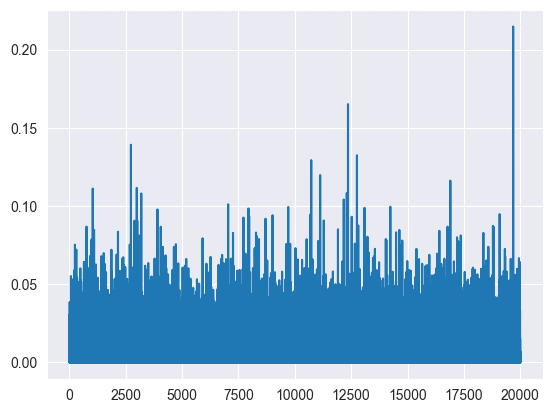

In [31]:
df['impurity'].plot()
plt.show()

In [32]:
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # Process tokens and update counter.
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # Create counter and run through all data.
    counter = Counter()
    df[column].progress_map(update)

    # Transform counter into data frame.
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    return freq_df.sort_values('freq', ascending=False)
    
def idf(df, column='tokens', preprocess=None, min_df=2):

    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(set(tokens))

    # Count tokens
    counter = Counter()
    df[column].progress_map(update)

    # Create data frame and compute idf
    idf_df = pd.DataFrame.from_dict(counter, orient='index', columns=['df'])
    idf_df = idf_df[idf_df['df'] >= min_df]
    idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1
    idf_df.index.name = 'token'
    return idf_df
    
    
def KWIC(*args, **kwargs):
    # call keyword_in_context with all params except 'print_only'
    return keyword_in_context(*args, 
                       **{kw: arg for kw, arg in kwargs.items() 
                        if kw != 'print_only'})

def kwic(doc_series, keyword, window=35, print_samples=5):

    def add_kwic(text):
        kwic_list.extend(KWIC(text, keyword, ignore_case=True, 
                              window_width=window, print_only=False))

    kwic_list = []
    doc_series.progress_map(add_kwic)

    if print_samples is None or print_samples==0:
        return kwic_list
    else:
        k = min(print_samples, len(kwic_list))
        print(f"{k} random samples out of {len(kwic_list)} contexts for '{keyword}':")
        for sample in random.sample(list(kwic_list), k):
            print(re.sub(r'[\n\t]', ' ', sample[0])+'  '+ \
                  sample[1]+'  '+\
                  re.sub(r'[\n\t]', ' ', sample[2]))

Check what tags might be included in the dataset.

In [33]:
count_words(df, column='text', preprocess=lambda t: re.findall(r'<[\w/]*>', t))

progress-bar:   0%|          | 0/20000 [00:00<?, ?it/s]

,freq
token,
<lb>,100729
<tab>,642


<a name='4.3.2'></a><a id='4.3.2'></a>
## 4.3.2 Blueprint: Removing Noise with Regular Expressions
<a href="#top">[back to top]</a>

This approach to data cleaning consists of defining a set of regex and identifying problematic patterns and corresponding substitution rules. 

In [34]:
def clean(text):
    # Convert html escapes like &amp; to characters.
    text = html.unescape(text) 
    # Tags like <tab>
    text = re.sub(r'<[^<>]*>', ' ', text)
    # Markdown URLs like [Some text](https://....)
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    # Text or code in brackets like [0]
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    # Standalone sequences of specials, matches &# but not #cool
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)
    # Standalone sequences of hyphens like --- or ==
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    # Sequences of white spaces
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()

---
Apply the `clean` function to the earlier sample text.

In [35]:
print(text)
HR()

clean_text = clean(text)
print(clean_text)
print("Impurity:", impurity(clean_text))


After viewing the [PINKIEPOOL Trailer](https://www.youtu.be/watch?v=ieHRoHUg)
it got me thinking about the best match ups.
<lb>Here's my take:<lb><lb>[](/sp)[](/ppseesyou) Deadpool<lb>[](/sp)[](/ajsly)
Captain America<lb>
----------------------------------------
After viewing the PINKIEPOOL Trailer it got me thinking about the best match ups. Here's my take: Deadpool Captain America
Impurity: 0.0


In [36]:
df['clean_text'] = df['text'].progress_map(clean)
df['impurity']   = df['clean_text'].apply(impurity, min_len=20)

progress-bar:   0%|          | 0/20000 [00:00<?, ?it/s]

---
Check the impurity of the cleaned text, and add further cleaning steps if necessary.

In [37]:
(
    df[['clean_text', 'impurity']]
    .sort_values(by='impurity', ascending=False) \
    .head(3)
)

,clean_text,impurity
14058,"Mustang 2018, 2019, or 2020? Must Haves!! 1. Have a Credit score of 780\+ for the best low inter...",0.030864
18934,"At the dealership, they offered an option for foot-well illumination, but I cannot find any refe...",0.026455
16505,"I am looking at four Caymans, all are in a similar price range. The major differences are the mi...",0.024631


In [38]:
df['impurity'].describe()

count    20000.000000
mean         0.000144
std          0.000982
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.030864
Name: impurity, dtype: float64

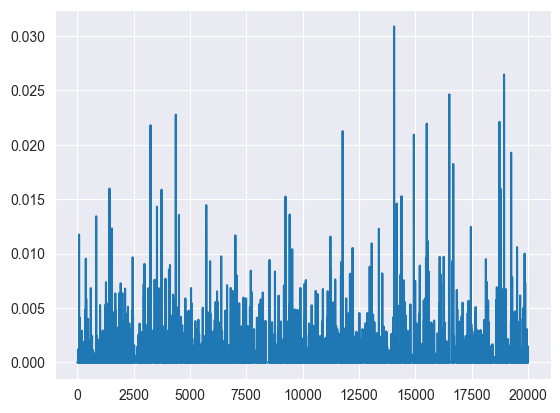

In [39]:
df['impurity'].plot()
plt.show()

<a name='4.3.3'></a><a id='4.3.3'></a>
## 4.3.3 Blueprint: Character Normalization with textacy
<a href="#top">[back to top]</a>

*textacy* is an NLP library built to work with spaCy. It leaves the linguistic part to spaCy and focuses on pre- and postprocessing. Thus, its preprocessing module comprises a nice collection of functions to normalize characters and to treat common patterns such as URLs, email addresses, telephone numbers, and so on.

Useful textacy preprocessing functions:

* `normalize_hyphenated_words`: Reassembles words that were separated by a line break
* `normalize_quotation_marks`: Replaces all kind of fancy quotation marks with an ASCII equivalent 
* `normalize_unicode:` Unifies different codes of accented characters in Unicode
* `remove_accents`: Replaces accented characters with ASCII, if possible, or drops them
* `replace_urls`: Similar for URLs like https://xyz.com
* `replace_emails`: Replaces emails with _EMAIL_
* `replace_hashtags`: Similar for tags like #sunshine
* `replace_numbers`: Similar for numbers like 1235
* `replace_phone_numbers`: Similar for telephone numbers +1 800 456-6553
* `replace_user_handles`: Similar for user handles like @pete
* `replace_emojis`: Replaces smileys etc. with _EMOJI_

In [40]:
text = "The café “Saint-Raphaël” is loca-\nted on Côte dʼAzur."

In [41]:
# Adjusted to textacy 0.11
def normalize(text):
    text = tprep.normalize.hyphenated_words(text)
    text = tprep.normalize.quotation_marks(text)
    text = tprep.normalize.unicode(text)
    text = tprep.remove.accents(text)
    return text

In [42]:
print(normalize(text))

The cafe "Saint-Raphael" is located on Cote d'Azur.


<a name='4.3.4'></a><a id='4.3.4'></a>
## 4.3.4 Blueprint: Pattern-Based Data Masking with textacy
<a href="#top">[back to top]</a>

In this example, find the most frequently used URLs in the corpus.

In [43]:
count_words(
    df, 
    column='clean_text', 
    preprocess=RE_URL.findall
).head(3)

progress-bar:   0%|          | 0/20000 [00:00<?, ?it/s]

,freq
token,
www.getlowered.com,3
http://www.ecolamautomotive.com/#!2/kv7fq,2
https://www.reddit.com/r/Jeep/comments/4ux232/just_ordered_an_android_head_unit_joying_jeep/,2


We want substitute all URLs in our text with replace_urls, which is a call to RE_URL.sub. 

In [44]:
replace_urls = textacy.preprocessing.replace.urls

text = "Check out https://spacy.io/usage/spacy-101"

# Using default substitution _URL_
print(replace_urls(text))

Check out _URL_


To finalize data cleaning, we apply the normalization and data masking functions to our data:

In [45]:
df['clean_text'] = df['clean_text'].progress_map(replace_urls)
df['clean_text'] = df['clean_text'].progress_map(normalize)

progress-bar:   0%|          | 0/20000 [00:00<?, ?it/s]

progress-bar:   0%|          | 0/20000 [00:00<?, ?it/s]

In [46]:
df['clean_text'].sample(3)

19328    I purchased a 2017 Sonata with great incentives last year. How do I go about finding what incent...
110      Absolutely loving my 2015 Mazda 3. I don't drive too hard, but I do like doing a bit of spirited...
1377     So I got my first car in May of last year, 200k+ miles and still runs well besides the fact that...
Name: clean_text, dtype: object

Rename the text columns so that `clean_text` becomes `text`, drop the impurity column, and store the new version of the DataFrame in the database.

In [47]:
df.rename(columns={'text': 'raw_text', 'clean_text': 'text'}, inplace=True)
df.drop(columns=['impurity'], inplace=True)

con = sqlite3.connect(db_name)
df.to_sql("posts_cleaned", con, index=False, if_exists="replace")
con.close()

In [48]:
df.head(3)

,id,subreddit,title,raw_text,category,subcategory,text
0,8f73s7,Harley,No Club Colors,Funny story. I went to college in Las Vegas. This was before I knew anything about motorcycling ...,autos,harley davidson,Funny story. I went to college in Las Vegas. This was before I knew anything about motorcycling ...
1,5s0q8r,Mustang,Roush vs Shleby GT500,"I am trying to determine which is faster, and I've seen the dealership video with the two racing...",autos,ford,"I am trying to determine which is faster, and I've seen the dealership video with the two racing..."
2,5z3405,Volkswagen,2001 Golf Wagon looking for some insight,Hello! <lb><lb>Trying to find some information on replacing a 2001 Golf Wagon starter (gas).... ...,autos,VW,Hello! Trying to find some information on replacing a 2001 Golf Wagon starter (gas).... mine's g...


<a name='4.4'></a><a id='4.4'></a>
# 4.4 Tokenization
<a href="#top">[back to top]</a>

Tokenization can be complex if we want to treat everything correctly. 

In [49]:
text = """
2019-08-10 23:32: @pete/@louis - I don't have a well-designed 
solution for today's problem. The code of module AC68 should be -1. 
Have to think a bit... #goodnight ;-) 😩😬"""

text

"\n2019-08-10 23:32: @pete/@louis - I don't have a well-designed \nsolution for today's problem. The code of module AC68 should be -1. \nHave to think a bit... #goodnight ;-) 😩😬"

<a name='4.4.1'></a><a id='4.4.1'></a>
## 4.4.1 Blueprint: Tokenization with Regular Expressions
<a href="#top">[back to top]</a>

Useful functions for tokenization are re.split() and re.findall(). 

However, in this very simple tokenizer, all the special characters and emojis are lost.

In [50]:
tokens = re.findall(r'\w\w+', text)

print(*tokens, sep='|')

2019|08|10|23|32|pete|louis|don|have|well|designed|solution|for|today|problem|The|code|of|module|AC68|should|be|Have|to|think|bit|goodnight


---
To improve our tokenizer, we add some additional expressions for the emojis, and create a reusable regex RE_TOKEN. The VERBOSE option allows readable formatting of complex expressions. 

In [51]:
RE_TOKEN = re.compile(
    r"""
    ( [#]?[@\w'’\.\-\:]*\w     # words, hash tags and email adresses
    | [:;<]\-?[\)\(3]          # coarse pattern for basic text emojis
    | [\U0001F100-\U0001FFFF]  # coarse code range for unicode emojis
    )
    """, re.VERBOSE
)

def tokenize(text):
    return RE_TOKEN.findall(text)

tokens = tokenize(text)
print(*tokens, sep='|')

2019-08-10|23:32|@pete|@louis|I|don't|have|a|well-designed|solution|for|today's|problem|The|code|of|module|AC68|should|be|-1|Have|to|think|a|bit|#goodnight|;-)|😩|😬


<a name='4.4.2'></a><a id='4.4.2'></a>
## 4.4.2 Tokenization with NLTK
<a href="#top">[back to top]</a>

The NLTK tokenizer is frequently used for tokenization.

In [52]:
tokens = nltk.tokenize.word_tokenize(text)
print(*tokens, sep='|')

2019-08-10|23:32|:|@|pete/|@|louis|-|I|do|n't|have|a|well-designed|solution|for|today|'s|problem|.|The|code|of|module|AC68|should|be|-1|.|Have|to|think|a|bit|...|#|goodnight|;|-|)|😩😬


In [53]:
# Not in book: Regex Tokenizer
# This is a wrapper for re.findall() with some added convenience functionality. 
tokenizer = nltk.tokenize.RegexpTokenizer(
    RE_TOKEN.pattern, 
    flags=re.VERBOSE
)
tokens = tokenizer.tokenize(text)
print(*tokens, sep='|')

2019-08-10|23:32|@pete|@louis|I|don't|have|a|well-designed|solution|for|today's|problem|The|code|of|module|AC68|should|be|-1|Have|to|think|a|bit|#goodnight|;-)|😩|😬


In [54]:
# Not in book: Tweet Tokenizer
# This is a regular-expression-based tokenizer.
tokenizer = nltk.tokenize.TweetTokenizer()
tokens = tokenizer.tokenize(text)
print(*tokens, sep='|')

2019-08-|10|23:32|:|@pete|/|@louis|-|I|don't|have|a|well-designed|solution|for|today's|problem|.|The|code|of|module|AC68|should|be|-|1|.|Have|to|think|a|bit|...|#goodnight|;-)|😩|😬


In [55]:
# Not in book: Toktok Tokenizer
# This is a regular-expression-based tokenizer.
tokenizer = nltk.tokenize.ToktokTokenizer()
tokens = tokenizer.tokenize(text)
print(*tokens, sep='|')

2019-08-10|23|:|32|:|@pete/@louis|-|I|don|'|t|have|a|well-designed|solution|for|today|'|s|problem.|The|code|of|module|AC68|should|be|-1.|Have|to|think|a|bit|...|#goodnight|;|-|)|😩😬


<a name='4.4.3'></a><a id='4.4.3'></a>
## 4.4.3 Recommendations for Tokenization
<a href="#top">[back to top]</a>

You will probably need to use custom regular expressions if you want high precision on domain-specific token patterns.

---
<a name='4.5'></a><a id='4.5'></a>
# 4.5 Linguistic Processing with spaCy
<a href="#top">[back to top]</a>

spaCy is a powerful library for linguistic data processing. It provides an integrated pipeline of processing components, by default a tokenizer, a part-of-speech tagger, a dependency parser, and a named-entity recognizer.

The philosophy of spaCy is that the original text is retained throughout the process. Instead of transforming it, spaCy adds layers of information. 

<a name='4.5.1'></a><a id='4.5.1'></a>
## 4.5.1 Instantiating a Pipeline
<a href="#top">[back to top]</a>

We instantiate an object of the spaCy language class by calling `spacy.load()` along with the name of the model file to use. 

Here we use the small English language model `en_core_web_sm`. The variable for the Language object is usually called `nlp`.

This Language object now contains the shared vocabulary, the model, and the processing pipeline.

In [56]:
nlp = spacy.load('en_core_web_sm')

nlp.pipeline

[('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec at 0x1481bf760>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x148112be0>),
 ('parser', <spacy.pipeline.dep_parser.DependencyParser at 0x149070580>),
 ('attribute_ruler',
  <spacy.pipeline.attributeruler.AttributeRuler at 0x1498d6b80>),
 ('lemmatizer', <spacy.lang.en.lemmatizer.EnglishLemmatizer at 0x1498e2980>),
 ('ner', <spacy.pipeline.ner.EntityRecognizer at 0x1490709e0>)]

---
Often you will only need the tokenizer and the part-of-speech tagger. In this case, you should disable the parser and named-entity recognition like this:

In [57]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

nlp.pipeline

[('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec at 0x14809a160>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x14806e400>),
 ('attribute_ruler',
  <spacy.pipeline.attributeruler.AttributeRuler at 0x14aa62c80>),
 ('lemmatizer', <spacy.lang.en.lemmatizer.EnglishLemmatizer at 0x14aa6cb00>)]

<a name='4.5.2'></a><a id='4.5.2'></a>
## 4.5.2 Processing Text
<a href="#top">[back to top]</a>

The pipeline is executed by calling the `nlp` object. The call returns an object of type `spacy.tokens.doc.Doc`, a container to access the tokens, spans (ranges of tokens), and their linguistic annotations.

In [58]:
nlp = spacy.load("en_core_web_sm")

text = "My best friend Ryan Peters likes fancy adventure games. gb@omame.com www.omame.com"
doc = nlp(text)

print(type(doc))
HR()
print(doc)

<class 'spacy.tokens.doc.Doc'>
----------------------------------------
My best friend Ryan Peters likes fancy adventure games. gb@omame.com www.omame.com


In [59]:
doc.tensor.shape

(12, 96)

`doc` is also a container object for the tokens, and you can use it as an iterator for tokens.

In [60]:
for i, token in enumerate(doc):
    print(i, token, end="|")

0 My|1 best|2 friend|3 Ryan|4 Peters|5 likes|6 fancy|7 adventure|8 games|9 .|10 gb@omame.com|11 www.omame.com|

This function generates a table containing the tokens and their attributes. 

In [61]:
def display_nlp(doc, include_punct=False):
    """Generate data frame for visualization of spaCy tokens."""
    rows = []
    for i, t in enumerate(doc):
        if not t.is_punct or include_punct:
            row = {'token': i,  
                   'text': t.text, 
                   'lemma_': t.lemma_, 
                   'is_stop': t.is_stop, 
                   'is_alpha': t.is_alpha,
                   'pos_': t.pos_, 
                   'dep_': t.dep_, 
                   'ent_type_': t.ent_type_, 
                   'ent_iob_': t.ent_iob_,
                   'head': t.head,
                   'is_alpha': t.is_alpha,
                   'like_email': t.like_email,
                   'like_url': t.like_url
                  }
            rows.append(row)
    
    df = pd.DataFrame(rows).set_index('token')
    df.index.name = None
    return df

display_nlp(doc)

,text,lemma_,is_stop,is_alpha,pos_,dep_,ent_type_,ent_iob_,head,like_email,like_url
0,My,my,True,True,PRON,poss,,O,friend,False,False
1,best,good,False,True,ADJ,amod,,O,friend,False,False
2,friend,friend,False,True,NOUN,nsubj,,O,likes,False,False
3,Ryan,Ryan,False,True,PROPN,compound,PERSON,B,Peters,False,False
4,Peters,Peters,False,True,PROPN,appos,PERSON,I,friend,False,False
5,likes,like,False,True,VERB,ROOT,,O,likes,False,False
6,fancy,fancy,False,True,ADJ,amod,,O,games,False,False
7,adventure,adventure,False,True,NOUN,compound,,O,games,False,False
8,games,game,False,True,NOUN,dobj,,O,likes,False,False
10,gb@omame.com,gb@omame.com,False,False,X,ROOT,,O,gb@omame.com,True,False


<a name='4.5.3'></a><a id='4.5.3'></a>
## 4.5.3 Blueprint: Customizing Tokenization
<a href="#top">[back to top]</a>

Tokenization is the first step in the pipeline, and everything depends on the correct tokens. spaCy’s tokenizer does a good job in most cases, but it splits on hash signs, hyphens, and underscores, which is sometimes not
what you want.

In [62]:
text = "@Pete: choose low-carb #food #eat-smart. _url_ ;-) 😋👍"
nlp = spacy.load('en_core_web_sm') ###
doc = nlp(text)

for token in doc:
    print(token, end="|")

@Pete|:|choose|low|-|carb|#|food|#|eat|-|smart|.|_|url|_|;-)|😋|👍|

To change the spaCy English tokenization rules and create correct tokens in the first place, create your own variant of the tokenizer with individual rules for infix, prefix, and suffix splitting.

In [63]:
def custom_tokenizer(nlp):
    
    # Use default patterns except the ones matched by re.search
    prefixes = [pattern for pattern in nlp.Defaults.prefixes 
                if pattern not in ['-', '_', '#']]
    suffixes = [pattern for pattern in nlp.Defaults.suffixes
                if pattern not in ['_']]
    infixes  = [pattern for pattern in nlp.Defaults.infixes
                if not re.search(pattern, 'xx-xx')]

    return Tokenizer(
        vocab          = nlp.vocab, 
        rules          = nlp.Defaults.tokenizer_exceptions,
        prefix_search  = compile_prefix_regex(prefixes).search,
        suffix_search  = compile_suffix_regex(suffixes).search,
        infix_finditer = compile_infix_regex(infixes).finditer,
        token_match    = nlp.Defaults.token_match
    )

nlp = spacy.load('en_core_web_sm')
nlp.tokenizer = custom_tokenizer(nlp)

doc = nlp(text)
for token in doc:
    print(token, end="|")

@Pete|:|choose|low-carb|#food|#eat-smart|.|_url_|;-)|😋|👍|

<a name='4.5.4'></a><a id='4.5.4'></a>
## 4.5.4 Blueprint: Working with Stop Words
<a href="#top">[back to top]</a>

spaCy uses language-specific stop word lists to set the `is_stop` property for each token directly after tokenization. So, filtering stop words (and similarly punctuation tokens) is easy.

In [64]:
nlp = spacy.load('en_core_web_sm')
text = "Dear Ryan, we need to sit down and talk. Regards, Pete"
doc = nlp(text)

non_stop = [t for t in doc if not t.is_stop and not t.is_punct]
print(non_stop)

[Dear, Ryan, need, sit, talk, Regards, Pete]


The list of English stop words with more than 300 entries can be accessed by importing `spacy.lang.en.STOP_WORDS`. When an nlp object is created, this list is loaded and stored under `nlp.Defaults.stop_words`. 

We can modify spaCy's default behavior by setting the `is_stop` property of the respective words in spaCy's vocabulary.

In [65]:
print(*nlp.Defaults.stop_words)

fifteen it eight except third has within still be top himself wherein hereupon both towards besides ca our due therefore few 'm should and take upon others does further cannot two would latter already amount hereby yourselves become again neither anywhere n’t back forty so everyone beside really yet whatever rather these ‘m my its too unless just off into i he whereby was yours six without from most per doing only n't when own together name ’re on each 'll will make afterwards elsewhere twenty every by whither while perhaps might yourself otherwise part if ourselves became ’ve re well they ’s amongst above ‘d however his whoever three latterly which beyond becomes there of been wherever those thence being empty whereupon had thru nor onto between eleven over none serious twelve themselves any what can ‘s namely nobody everything in with toward but ’m beforehand about until show hundred move ten throughout seem during not fifty must although once ours itself her then put such us nothing

In [66]:
nlp = spacy.load('en_core_web_sm')
nlp.vocab['down'].is_stop = False
nlp.vocab['Dear'].is_stop = True
nlp.vocab['Regards'].is_stop = True

# Rerun the previous example. Need to rerun nlp(text).
doc = nlp(text)
non_stop = [t for t in doc if not t.is_stop and not t.is_punct]

print(non_stop)

[Ryan, need, sit, down, talk, Pete]


### Not in book: Modifying stop words with a language subclass

Modifying the stop word by changing the vocabulary will probably become deprecated with spaCy 3.0. Instead it is recommended to create a subclass of the respective language like this:

In [67]:
# Not in book: subclass approach to modify stop word lists.
# Recommended from spaCy version 3.0 onwards.
excluded_stop_words = {'down'}
included_stop_words = {'dear', 'regards'}

class CustomEnglishDefaults(English.Defaults):
    stop_words = English.Defaults.stop_words.copy()
    stop_words -= excluded_stop_words
    stop_words |= included_stop_words
    
class CustomEnglish(English):
    Defaults = CustomEnglishDefaults

nlp = CustomEnglish()
text = "Dear Ryan, we need to sit down and talk. Regards, Pete"
doc = nlp.make_doc(text) # Only tokenize

print(doc)
HR()

tokens_wo_stop = [token for token in doc ] 
for token in doc:
    if not token.is_stop and not token.is_punct:
        print(token, end='|')

Dear Ryan, we need to sit down and talk. Regards, Pete
----------------------------------------
Ryan|need|sit|down|talk|Pete|

In [68]:
# Reset nlp to original
nlp = spacy.load('en_core_web_sm')

<a name='4.5.5'></a><a id='4.5.5'></a>
## 4.5.5 Blueprint: Extracting Lemmas based on Part-of-Speech
<a href="#top">[back to top]</a>

Lemmatization is the mapping of a word to its uninflected root. The correct assignment of the lemma requires a lookup dictionary and knowledge about the part of speech of a word.

Here, the lemma of a token or span can be accessed by the `lemma_` property in spaCy.

In [69]:
text = "My best friend Ryan Peters likes fancy adventure games."
doc = nlp(text)

print(*[t.lemma_ for t in doc], sep='|')

my|good|friend|Ryan|Peters|like|fancy|adventure|game|.


Often, we are interested only in content words. Thus, instead of using a stop word list, we can use part-of-speech tags to select the word types we are interested in and discard the rest. For example, a list containing only the nouns and proper nouns in a doc can be generated like this.

In [70]:
text = "My best friend Ryan Peters likes fancy adventure games."
doc = nlp(text)

nouns = [t for t in doc if t.pos_ in ['NOUN', 'PROPN']]
print(nouns)

[friend, Ryan, Peters, adventure, games]


---
Universal part-of-speech tags:

```
ADJ Adjectives (describe nouns)
ADP Adpositions (prepositions and postpositions)
ADV Adverbs (modify verbs or adjectives)
AUX Auxiliary (accompanies verb)
CCONJ Connecting conjunction
DET Determiner (with regard to nouns)
INTJ Interjection (independent word, exclamation, expression of emotion) NOUN Nouns (common and proper)
NUM Cardinal numbers
PROPN Proper noun, name, or part of a name
PRON Pronoun, substitute for noun
PART Particle (makes sense only with other word)
PUNCT Punctuation characters
SCONJ Subordinating conjunction
SYM Symbols (word-like)
VERB Verbs (all tenses and modes)
X Anything that cannot be assigned
```

---
Here, we extract tokens for adjectives and nouns from the sample sentence.

In [71]:
tokens = textacy.extract.words(
    doc, 
    filter_stops = True,           # default True, no stopwords
    filter_punct = True,           # default True, no punctuation
    filter_nums = True,            # default False, no numbers
    include_pos = ['ADJ', 'NOUN'], # default None = include all
    exclude_pos = None,            # default None = exclude none
    min_freq = 1                   # minimum frequency of words
)

print(*[t for t in tokens], sep='|')

best|friend|fancy|adventure|games


---
Our blueprint function to extract a filtered list of word lemmas is finally just a tiny wrapper around that function. By forwarding the keyword arguments `(**kwargs)`, this function accepts the same parameters as textacy's `extract.words`.

In [72]:
def extract_lemmas(doc, **kwargs):
    return [t.lemma_ for t in textacy.extract.words(doc, **kwargs)]

lemmas = extract_lemmas(doc, include_pos=['ADJ', 'NOUN'])
print(*lemmas, sep='|')

good|friend|fancy|adventure|game


<a name='4.5.6'></a><a id='4.5.6'></a>
## 4.5.6 Blueprint: Extracting Noun Phrases
<a href="#top">[back to top]</a>

When we create n-grams, many of them are not very useful for analysis (eg `likes_fancy`, `my_best`). How can we detect word sequences that have real meaning?

One way is to apply pattern-matching on the part-of-speech tags. spaCy has a powerful rule-based matcher, and textacy has a convenient wrapper for pattern-based phrase extraction. 

The following pattern extracts sequences of nouns with a preceding adjective.

In [73]:
text = "My best friend Ryan Peters likes fancy adventure games."
doc = nlp(text)
print(doc)
HR()

patterns = ["POS:ADJ POS:NOUN:+"]

# New textacy version
spans = textacy.extract.matches.token_matches(doc, patterns=patterns)

print(*[s.lemma_ for s in spans], sep='|')

My best friend Ryan Peters likes fancy adventure games.
----------------------------------------
good friend|fancy adventure|fancy adventure game


---
We can also use spaCy's `doc.noun_chunks` for noun phrase extraction. However, the returned chunks can also include pronouns and determiners, which make it less suited for feature extraction.

In [74]:
print(*doc.noun_chunks, sep='|')

My best friend|Ryan Peters|fancy adventure games


---
Here we define a blueprint for noun phrase extraction based on part-of-speech patterns. 

The function takes a doc, a list of part-of-speech tags, and a separator character to join the words of the noun phrase. 

The constructed pattern searches for sequences of nouns that are preceded by a token with one of the specified part-of-speech tags. 

Returned are the lemmas. Our example extracts all phrases consisting of an adjective or a noun followed by a sequence of nouns.

In [75]:
def extract_noun_phrases(doc, preceding_pos=['NOUN'], sep='_'):
    patterns = []
    for pos in preceding_pos:
        patterns.append(f"POS:{pos} POS:NOUN:+")

    # Assume textacy.__version__ > '0.11':
    spans = textacy.extract.matches.token_matches(doc, patterns=patterns)

    return [sep.join([t.lemma_ for t in s]) for s in spans]


print(*extract_noun_phrases(doc, ['ADJ', 'NOUN']), sep='|')

good_friend|fancy_adventure|fancy_adventure_game|adventure_game


<a name='4.5.7'></a><a id='4.5.7'></a>
## 4.5.7 Blueprint: Extracting Named Entities
<a href="#top">[back to top]</a>

Named-entity recognition refers to the process of detecting entities such as people, locations, or organizations in text. Each entity can consist of one or more tokens, like San Francisco. Therefore, named entities are represented by `Span` objects. As with noun phrases, it can be helpful to retrieve a list of named entities for further analysis.

In [76]:
text = "James O'Neill, chairman of World Cargo Inc, lives in San Francisco."
doc = nlp(text)

for ent in doc.ents:
    print(f"({ent.text}, {ent.label_})", end=" ")

(James O'Neill, PERSON) (World Cargo Inc, ORG) (San Francisco, GPE) 

In [77]:
displacy.render(doc, style='ent', jupyter=True)

For the extraction of named entities of certain types, we can make use of one of textacy's convenient functions.


In [78]:
def extract_entities(doc, include_types=None, sep='_'):

    ents = textacy.extract.entities(doc, 
             include_types=include_types, 
             exclude_types=None, 
             drop_determiners=True, 
             min_freq=1)
    
    return [sep.join([t.lemma_ for t in e])+'/'+e.label_ for e in ents]

In [79]:
print(extract_entities(doc, ['PERSON', 'GPE']))

["James_O'Neill/PERSON", 'San_Francisco/GPE']


---
<a name='4.6'></a><a id='4.6'></a>
# 4.6 Feature Extraction on a Large Dataset
<a href="#top">[back to top]</a>

<a name='4.6.1'></a><a id='4.6.1'></a>
## 4.6.1 Blueprint: Creating One Function to Get It All
<a href="#top">[back to top]</a>

This blueprint function combines all the extraction functions from the previous section. It neatly puts everything we want to extract in one place in the code so that the subsequent steps do not need to be adjusted if you add or change something here.

In [80]:
def extract_nlp(doc):
    PARTS = ['PART', 'PUNCT', 'DET', 'PRON', 'SYM', 'SPACE']
    
    # Return a dict
    return {
        'lemmas'          : extract_lemmas(doc, exclude_pos = PARTS, filter_stops = False),
        'adjs_verbs'      : extract_lemmas(doc, include_pos = ['ADJ', 'VERB']),
        'nouns'           : extract_lemmas(doc, include_pos = ['NOUN', 'PROPN']),
        'noun_phrases'    : extract_noun_phrases(doc, ['NOUN']),
        'adj_noun_phrases': extract_noun_phrases(doc, ['ADJ']),
        'entities'        : extract_entities(doc, ['PERSON', 'ORG', 'GPE', 'LOC'])
    }

In [81]:
nlp = spacy.load('en_core_web_sm')

The function returns a dictionary with everything we want to extract, as shown in this example.

In [82]:
# Input
text = "My best friend Ryan Peters likes fancy adventure games."
doc = nlp(text)
type(doc)

spacy.tokens.doc.Doc

In [83]:
# Simple output from extract_nlp
extract_nlp(doc)

{'lemmas': ['good',
  'friend',
  'Ryan',
  'Peters',
  'like',
  'fancy',
  'adventure',
  'game'],
 'adjs_verbs': ['good', 'like', 'fancy'],
 'nouns': ['friend', 'Ryan', 'Peters', 'adventure', 'game'],
 'noun_phrases': ['adventure_game'],
 'adj_noun_phrases': ['good_friend',
  'fancy_adventure',
  'fancy_adventure_game'],
 'entities': ['Ryan_Peters/PERSON']}

In [84]:
# Much cleaner output from extract_nlp
for col, values in extract_nlp(doc).items():
    print(f"{col: <20}: {values}")

lemmas              : ['good', 'friend', 'Ryan', 'Peters', 'like', 'fancy', 'adventure', 'game']
adjs_verbs          : ['good', 'like', 'fancy']
nouns               : ['friend', 'Ryan', 'Peters', 'adventure', 'game']
noun_phrases        : ['adventure_game']
adj_noun_phrases    : ['good_friend', 'fancy_adventure', 'fancy_adventure_game']
entities            : ['Ryan_Peters/PERSON']


---
The list of returned column names is needed for the next steps. Instead of hardcoding it, we just call `extract_nlp` with an empty document to retrieve the list.

```
nlp.make_doc

Turn a text into a Doc object.

text (str): The text to process.
RETURNS (Doc): The processed doc.

```

In [85]:
# Test to get column names
extract_nlp(nlp.make_doc(''))

{'lemmas': [],
 'adjs_verbs': [],
 'nouns': [],
 'noun_phrases': [],
 'adj_noun_phrases': [],
 'entities': []}

In [86]:
# Cleaner way to retrieve column names
nlp_columns = list(extract_nlp(nlp.make_doc('')).keys())

print(nlp_columns)

['lemmas', 'adjs_verbs', 'nouns', 'noun_phrases', 'adj_noun_phrases', 'entities']


In [87]:
# Another way, using only the constructor nlp('')
print(list(extract_nlp(nlp(''))))

['lemmas', 'adjs_verbs', 'nouns', 'noun_phrases', 'adj_noun_phrases', 'entities']


<a name='4.6.2'></a><a id='4.6.2'></a>
## 4.6.2 Blueprint: Using spaCy on a Large Dataset
<a href="#top">[back to top]</a>

We can use this function to extract features from all the records of a dataset. We take the cleaned texts that we created and saved at the beginning of this chapter and add the titles.

In [88]:
db_name = "reddit-selfposts.db"
con = sqlite3.connect(db_name)
df = pd.read_sql("select * from posts_cleaned", con)
con.close()

df['text'] = df['title'] + ': ' + df['text']

df.sample(2)

,id,subreddit,title,raw_text,category,subcategory,text
18880,7gjidl,BMW,325i E90 MPG Problem!,Recently my 2006 325i has been acting very strange. My gas mileage calculator was showing an ave...,autos,bmw,325i E90 MPG Problem!: Recently my 2006 325i has been acting very strange. My gas mileage calcul...
15340,7bp63c,mercedes_benz,Front left strut replacement,I need a new left strut. Mechanics say the part is 600$ i got the part number and found one onli...,autos,mercedes,Front left strut replacement: I need a new left strut. Mechanics say the part is 600$ i got the ...


Before we start NLP processing, we initialize the new DataFrame columns we want to fill with values.

In [89]:
for col in nlp_columns:
    df[col] = None
    
df[col]

0        None
1        None
2        None
3        None
4        None
         ... 
19995    None
19996    None
19997    None
19998    None
19999    None
Name: entities, Length: 20000, dtype: object

Now we have to decide which model and which of the pipeline components to use. Remember to disable unneccesary components to improve runtime.

We stick to the small English model with the default pipeline and use our custom tokenizer that splits on hyphens.

In [90]:
nlp = spacy.load('en_core_web_sm', disable=[])

# Optional Use default patterns except the ones matched by re.search
nlp.tokenizer = custom_tokenizer(nlp)

In [91]:
# Full data set takes about 6-8 minutes
# For faster processing use a sample like this:
df_sm = df.sample(500)

df_sm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 5283 to 19243
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                500 non-null    object
 1   subreddit         500 non-null    object
 2   title             500 non-null    object
 3   raw_text          500 non-null    object
 4   category          500 non-null    object
 5   subcategory       500 non-null    object
 6   text              500 non-null    object
 7   lemmas            0 non-null      object
 8   adjs_verbs        0 non-null      object
 9   nouns             0 non-null      object
 10  noun_phrases      0 non-null      object
 11  adj_noun_phrases  0 non-null      object
 12  entities          0 non-null      object
dtypes: object(13)
memory usage: 54.7+ KB


* When processing larger datasets, it is recommended to use spaCy’s batch processing for a significant performance gain (roughly factor 2 on our dataset). 

* The function nlp.pipe takes an iterable of texts, processes them internally as a batch, and yields a list of processed Doc objects in the same order as the input data.

* To use it, we first have to define a batch size. 

* Then we can loop over the batches and call nlp.pipe.

In [92]:
batch_size = 50
batches = math.ceil(len(df_sm) / batch_size)
print(batches)

10


In [93]:
%%time
for i in tqdm(range(0, len(df_sm), batch_size), total=batches):
    docs = nlp.pipe(df['text'][i:i+batch_size])
    
    for j, doc in enumerate(docs):
        
        # Call our custom function extract_nlp here
        for col, values in extract_nlp(doc).items():
            df_sm[col].iloc[i+j] = values

  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 9.09 s, sys: 1.39 s, total: 10.5 s
Wall time: 10.7 s


In [94]:
df_sm[['text', 'lemmas', 'nouns', 'noun_phrases', 'entities']].sample(1)

,text,lemmas,nouns,noun_phrases,entities
11296,"'95 850, steering column replacement: Hi fellow Volvo drivers, I have posted here previously wit...","[thought, on, Model, X, after, 1, week, and, P90D, Model, S, and, P90D, Model, X, loaner, 've, h...","[thought, Model, X, week, P90D, Model, S, P90D, Model, X, loaner, week, thought, people, Model, ...","[thought_people, loaner_vehicle, delivery_day, software_bug, row_seat, value_proposition]","[P90D_Model_S/ORG, Model_S_p90d._considerably/ORG, FWD/ORG, Tesla/PERSON, P90D_S/ORG, Tesla/ORG]"


The newly created columns are perfectly suited for frequency analysis.

We can check for the most frequently mentioned noun phrases in the autos category.

progress-bar:   0%|          | 0/500 [00:00<?, ?it/s]

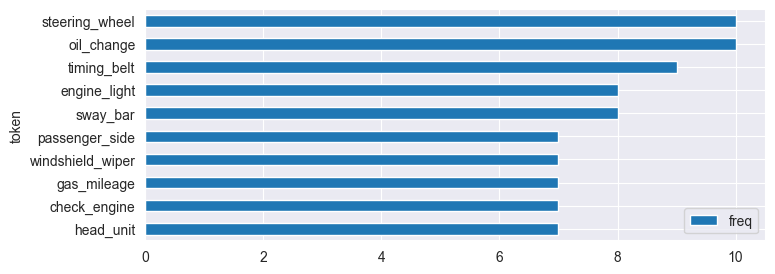

In [95]:
(
    count_words(df_sm, 'noun_phrases')
        .head(10)
        .plot(kind='barh', figsize=(8,3))
        .invert_yaxis()
)

<a name='4.6.3'></a><a id='4.6.3'></a>
## 4.6.3 Persisting the Result
<a href="#top">[back to top]</a>

Save the complete DataFrame to SQLite. 

For this, we need to serialize the extracted lists to space-separated strings, as lists are not supported by most databases.

In [96]:
df_sm[nlp_columns] = df_sm[nlp_columns].applymap(lambda items: ' '.join(items))

In [97]:
df_sm[nlp_columns].head()

,lemmas,adjs_verbs,nouns,noun_phrases,adj_noun_phrases,entities
5283,no Club color funny story go to college in Las Vegas be before know about motorcycle whatsoever ...,funny go know motorcycle end call worth note work outdrink read lose head assume bright red yell...,Club color story college Las Vegas college buddy strip dance club bar Hogs Heifers female sign d...,college_buddy dance_club,funny_story front_door bright_color xtra_t-shirt much_booze,Las_Vegas/GPE Hogs_Heifers/PERSON ANYONE/PERSON
4092,roush vs Shleby GT500 be try determine be fast and 've see dealership video with two racing(rous...,try determine see win wonder bigass find trustworthy,roush Shleby GT500 dealership video racing(roush supercharger Roush spec website source kind thing,dealership_video,bigass_supercharger same_spec trustworthy_source,Shleby_GT500/ORG
5385,2001 Golf Wagon look for insight hello try find information on replace 2001 Golf Wagon starter g...,look try find replace go go big live wonder international recommend replace oh-so-specific mention,Golf Wagon insight information Golf Wagon starter gas dealership range rush Japan shipping websi...,shipping_website,international_shipping international_shipping_website,Wagon/PERSON Wagon/PERSON Japan/GPE
12561,be 250 Coolant Flush change _URL_ have IS 250 AWD from 2006 about 73 k mile on 've never touch e...,touch find change say long flushed change wait,Coolant Flush change _URL_ AWD k mile engine radiator coolant book life Toyota coolant year,k_mile engine_radiator engine_radiator_coolant radiator_coolant,long_life,AWD/ORG
3331,Gen1 mpg w/ dead battery hi new to subreddit be consider buy Gen1 Volt but can find straight ans...,dead new consider buy find straight get dead gen1 deplete,Gen1 mpg w/ battery subreddit Gen1 Volt answer kind mpg battery mile trip kind highway mpg volt ...,mpg_w/ mile_trip highway_mpg,dead_battery straight_answer gen1_volt,Gen1_Volt/GPE


In [98]:
con = sqlite3.connect(db_name) 
df_sm.to_sql("posts_nlp", con, index=False, if_exists="replace")
con.close()

In [99]:
df_sm[nlp_columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 5283 to 19243
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   lemmas            500 non-null    object
 1   adjs_verbs        500 non-null    object
 2   nouns             500 non-null    object
 3   noun_phrases      500 non-null    object
 4   adj_noun_phrases  500 non-null    object
 5   entities          500 non-null    object
dtypes: object(6)
memory usage: 27.3+ KB


In [100]:
df_sm[nlp_columns].sample(1)

,lemmas,adjs_verbs,nouns,noun_phrases,adj_noun_phrases,entities
19729,model 3 card + walk away lock so scenario just cross mind do seem too unlikely phone go flat as ...,walk cross unlikely go flat size jump grab habit android know walk lock need specific detect mis...,model card lock scenario mind phone case day usage wallet glove compartment keycard point credit...,glove_compartment credit_card apple_pay car_lock,full_day specific_spot mobile_reception,android/ORG rfid/ORG Tesla/ORG Australia/GPE


In [101]:
df_sm.sample(1).T

,9614
id,6xwomv
subreddit,Lexus
title,Tuning a 2jz-he in a 01-04 gs300
raw_text,Hello everyone! I'm trying to buy a gs300 with a 2jz and I'd like to turbo it. This leads me to ...
category,autos
subcategory,lexus
text,Tuning a 2jz-he in a 01-04 gs300: Hello everyone! I'm trying to buy a gs300 with a 2jz and I'd l...
lemmas,C30 start issue hello just enter Volvo world few week ago and have run into first issue so since...
adjs_verbs,start enter run purchase notice start start quick start think big turn turn start start happen l...
nouns,C30 issue Volvo world week issue c30 car deal yesterday morning key dash light attempt thing wor...


<a name='4.6.4'></a><a id='4.6.4'></a>
## 4.6.4 A Note on Execution Time
<a href="#top">[back to top]</a>

Complete linguistic processing is really time-consuming. In fact, processing just the 20,000 Reddit posts with spaCy takes several minutes. A simple regexp tokenizer, in contrast, takes only a few seconds to tokenize all records on the same machine. It’s the tagging, parsing, and named-entity recognition that’s expensive, even though spaCy is really fast compared to other libraries. So if you don’t need named entities, you should definitely disable the parser and name-entity recognition to save more than 60% of the runtime.

Processing the data in batches with nlp.pipe and using GPUs is one way to speed up data processing for spaCy. But data preparation in general is also a perfect candidate for parallelization. One option to parallelize tasks in Python is using the library multi processing. Especially for the parallelization of operations on dataframes, there are some scalable alternatives to Pandas worth checking, namely Dask, Modin, and Vaex. pandarallel is a library that adds parallel apply operators directly to Pandas.

In any case, it is helpful to watch the progress and get a runtime estimate. As already mentioned in Chapter 1, the tqdm library is a great tool for that purpose because it provides progress bars for iterators and dataframe operations. Our notebooks on Git‐ Hub use tqdm whenever possible.

<a name='4.7'></a><a id='4.7'></a>
# 4.7 There is More
<a href="#top">[back to top]</a>

There are additional aspects besides data cleaning and linguistic processing. 

<a name='4.7.1'></a><a id='4.7.1'></a>
## 4.7.1 Additional Blueprint (not in book): Language Detection with fastText
<a href="#top">[back to top]</a>

* There are different trained models available on the fastText website. 
* We will be using the smaller model `lid.176.ftz` which has a size of less than 1 MB and is almost as accurate as the large model with 126MB. 
* See <https://fasttext.cc/docs/en/language-identification.html> for instructions.

In [102]:
# Download model
model_file = 'lid.176.ftz'
!wget -nc -q https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.ftz
!ls -l {model_file}

-rw-r--r--  1 gb  staff  938013 Jan 19  2019 lid.176.ftz


After downloading, we load the model and make a first prediction with the following lines of code:

In [103]:
lang_model = fasttext.load_model(model_file)

In [104]:
# Make a prediction
lang_model.predict(
    '"Good morning" in German is "Guten Morgen"', 3
)

(('__label__en', '__label__de', '__label__te'),
 array([0.97039694, 0.00256404, 0.00231963]))

The `predict` function takes a Unicode string as its first argument. The second, optional parameter `k` specifies that we want the `k` language labels with the highest probabilities.

The model returns labels in the form `__label__<code>`, where code is the ISO 639 language code`<footnote>`See <https://en.wikipedia.org/wiki/List_of_ISO_639-1_codes> for a complete list.`</footnote>` and probabilites for each label. 

Let's wrap the language identification into a preprocessing function. The function returns the detected language only if the calculated probability is higher than the specified threshold, otherwise, it returns the default language. This is useful for corpora like the hacker news, which is basically an English corpus with some utterances from other languages.

In [105]:
def predict_language(text, threshold=0.8, default='en'):
    
    # Skip language detection for very short texts.
    if len(text) < 20:
        return default

    # Fasttext requires single line input.
    text = text.replace('\n', ' ')
    
    labels, probas = lang_model.predict(text)
    lang = labels[0].replace("__label__", "")
    proba = probas[0]
    
    if proba < threshold:
        return default
    else:
        return lang

The prediction function can now easily be applied to a data frame to identify the language of each document.

In [106]:
data = ["I don't like version 2.0 of Chat4you 😡👎",   # English
        "Ich mag Version 2.0 von Chat4you nicht 😡👎", # German
        "Мне не нравится версия 2.0 Chat4you 😡👎",    # Russian
        "Não gosto da versão 2.0 do Chat4you 😡👎",    # Portugese
        "मुझे Chat4you का संस्करण 2.0 पसंद नहीं है 😡👎"]   # Hindi

demo_df = pd.Series(data, name='text').to_frame()

# Create new column
demo_df['lang'] = demo_df['text'].apply(predict_language)

demo_df

,text,lang
0,I don't like version 2.0 of Chat4you 😡👎,en
1,Ich mag Version 2.0 von Chat4you nicht 😡👎,de
2,Мне не нравится версия 2.0 Chat4you 😡👎,ru
3,Não gosto da versão 2.0 do Chat4you 😡👎,pt
4,मुझे Chat4you का संस्करण 2.0 पसंद नहीं है 😡👎,hi


In order to get the real names for the language codes, we can provide a mapping dictionary. 

In [107]:
iso_file = 'iso_639-1.csv'
!wget -nc -q https://raw.githubusercontent.com/haliaeetus/iso-639/master/data/iso_639-1.csv
!ls -l {iso_file}

-rw-r--r--  1 gb  staff  10811 Mar 30 23:26 iso_639-1.csv


In [108]:
lang_df = pd.read_csv(iso_file)
lang_df = lang_df[['name', '639-1', '639-2']].melt(id_vars=['name'], var_name='iso', value_name='code')

lang_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368 entries, 0 to 367
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    368 non-null    object
 1   iso     368 non-null    object
 2   code    368 non-null    object
dtypes: object(3)
memory usage: 8.8+ KB


In [109]:
# Create dictionary with entries {'code': 'name'}
iso639_languages = lang_df.set_index('code')['name'].to_dict()

# Check
pd.DataFrame(iso639_languages, index=[0]).T.head()

,0
ab,Abkhaz
aa,Afar
af,Afrikaans
ak,Akan
sq,Albanian


And we add this to our original data frame:

In [110]:
demo_df['lang_name'] = demo_df['lang'].map(iso639_languages)

demo_df

,text,lang,lang_name
0,I don't like version 2.0 of Chat4you 😡👎,en,English
1,Ich mag Version 2.0 von Chat4you nicht 😡👎,de,German
2,Мне не нравится версия 2.0 Chat4you 😡👎,ru,Russian
3,Não gosto da versão 2.0 do Chat4you 😡👎,pt,Portuguese
4,मुझे Chat4you का संस्करण 2.0 पसंद नहीं है 😡👎,hi,Hindi


<a name='4.7.2'></a><a id='4.7.2'></a>
## 4.7.2 Spell Checking (not in book)
<a href="#top">[back to top]</a>

[SymSpell](https://github.com/wolfgarbe/SymSpell) is a popular spell-checker with a [Python port](https://github.com/mammothb/symspellpy).


### Load frequency dictionary

https://symspellpy.readthedocs.io/en/latest/examples/dictionary.html

In [111]:
from itertools import islice
import pkg_resources
from symspellpy import SymSpell

sym_spell = SymSpell()
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt"
)
sym_spell.load_dictionary(dictionary_path, 0, 1)

# Print out first 5 elements to show that dictionary is successfully loaded
print(list(islice(sym_spell.words.items(), 5)))

[('the', 23135851162), ('of', 13151942776), ('and', 12997637966), ('to', 12136980858), ('a', 9081174698)]


### Basic usage

In [112]:
import pkg_resources
from symspellpy import SymSpell, Verbosity

sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)

dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt"
)

# term_index is the column of the term and count_index is the
# column of the term frequency
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

# lookup suggestions for single-word input strings
input_term = "memebers"  # misspelling of "members"

# max edit distance per lookup
# (max_edit_distance_lookup <= max_dictionary_edit_distance)
suggestions = sym_spell.lookup(input_term, Verbosity.CLOSEST, max_edit_distance=2)

# display suggestion term, edit distance, and term frequency
for suggestion in suggestions:
    print(suggestion)

members, 1, 226656153


### Lookup compound

In [113]:
import pkg_resources
from symspellpy import SymSpell

sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt"
)
bigram_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_bigramdictionary_en_243_342.txt"
)
# term_index is the column of the term and count_index is the
# column of the term frequency
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)

# lookup suggestions for multi-word input strings (supports compound
# splitting & merging)
input_term = (
    "whereis th elove hehad dated forImuch of thepast who "
    "couqdn'tread in sixtgrade and ins pired him"
)
# max edit distance per lookup (per single word, not per whole input string)
suggestions = sym_spell.lookup_compound(input_term, max_edit_distance=2)
# display suggestion term, edit distance, and term frequency
for suggestion in suggestions:
    print(suggestion)

where is the love he had dated for much of the past who couldn't read in six grade and inspired him, 9, 0


### Word segmentation

In [114]:
import pkg_resources
from symspellpy.symspellpy import SymSpell

# Set max_dictionary_edit_distance to avoid spelling correction
sym_spell = SymSpell(max_dictionary_edit_distance=0, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt"
)
# term_index is the column of the term and count_index is the
# column of the term frequency
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

# a sentence without any spaces
input_term = "thequickbrownfoxjumpsoverthelazydog"
result = sym_spell.word_segmentation(input_term)
print(f"{result.corrected_string}, {result.distance_sum}, {result.log_prob_sum}")

the quick brown fox jumps over the lazy dog, 8, -34.491167981910635


<a name='4.7.3'></a><a id='4.7.3'></a>
## 4.7.3 Token Normalization
<a href="#top">[back to top]</a>

Often, there are different spellings for identical terms or variations of terms that you want to treat and especially count identically. In this case, it is useful to normalize these terms and map them to a common standard. Here are some examples:

* U.S.A. or U.S. → USA
* dot-com bubble → dotcom bubble
* München → Munich

You could use spaCy's phrase matcher to integrate this kind of normalization as a post-processing step into its pipeline. If you don't use spaCy, you can use a simple Python dictionary to map different spellings to their normalized forms.

In [115]:
# Not in book: Normalize tokens with a dict
token_map = { 
    'U.S.': 'United_States',
    'L.A.': 'Los_Angeles' 
}

def token_normalizer(tokens):
    return [token_map.get(t, t) for t in tokens]

tokens = "L.A. is a city in the U.S.".split()
tokens = token_normalizer(tokens)

print(*tokens, sep='|')

Los_Angeles|is|a|city|in|the|United_States
